In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio
import astropy.coordinates
import astropy.time
import time
import astropy.io.fits as fits

In [2]:
data_noise_on = []
data_noise_off = []

In [3]:
data_noise_off_example = fits.open('../Data/celestial_pole-noiseoff_' + str(0) + '.fits')

In [4]:
for i in range(0, 386):
    d_off_avg = []
    d_on_avg = []
    for j in range(1, 21):
        d_off = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
        d_off = d_off[j].data['auto0_real']
        d_off_avg.append(d_off)
    d_off_avg = np.mean(d_off_avg, axis=0)
    data_noise_off.append(d_off_avg)
    
    for k in range(1, 3):
        d_on = fits.open('../Data/celestial_pole-noiseon_' + str(i) + '.fits')[k].data['auto0_real']
        d_on_avg.append(d_on)
    d_on_avg = np.mean(d_on_avg, axis=0)
    data_noise_on.append(d_on_avg)

In [5]:
#open more data
off_data2_avg = []
off_data_2 = []

on_data_2 = []
for i in range(43,49,2):
    for j in range(105,159,2):
        off_data2_avg = []
        #try:
        for k in range(1,21):
            off_data2 = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + str(j)+'.fits')
            off_data2 =off_data2[k].data['auto0_real']
            off_data2_avg.append(off_data2)
        off_data2_avg = np.mean(off_data2_avg, axis=0) 
        off_data_2.append(off_data2_avg)
        #except:  
            #continue 

In [6]:
for i in range(43,49,2):
    for j in range(105,159,2):
        on_data2_avg = []
        #try:
        for k in range(1,3):
            on_data2 = fits.open('../Data/celestial_pole-noiseon_' + str(i) + str(j)+'.fits')
            on_data2 =on_data2[k].data['auto0_real']
            on_data2_avg.append(on_data2)
        on_data2_avg = np.mean(on_data2_avg, axis=0) 
        on_data_2.append(on_data2_avg)
        #except:  
            #continue
            

In [7]:
#combine the two datas
#combine data off 
data_noise_off2 = data_noise_off.extend(off_data_2)

#combine data on 
data_noise_on2 = data_noise_on.extend(on_data_2)

In [8]:
hdr = dict(data_noise_off_example[0].header)
if_freq = 144 + np.arange(0, hdr['NCHAN']) * hdr['RES'] / 1e6
rf_freq = if_freq + 2*635

# this is wrong and stupid
data_noise_on_average = np.mean(data_noise_on, axis=0)
data_noise_off_average = np.mean(data_noise_off, axis=0)

<IPython.core.display.Javascript object>


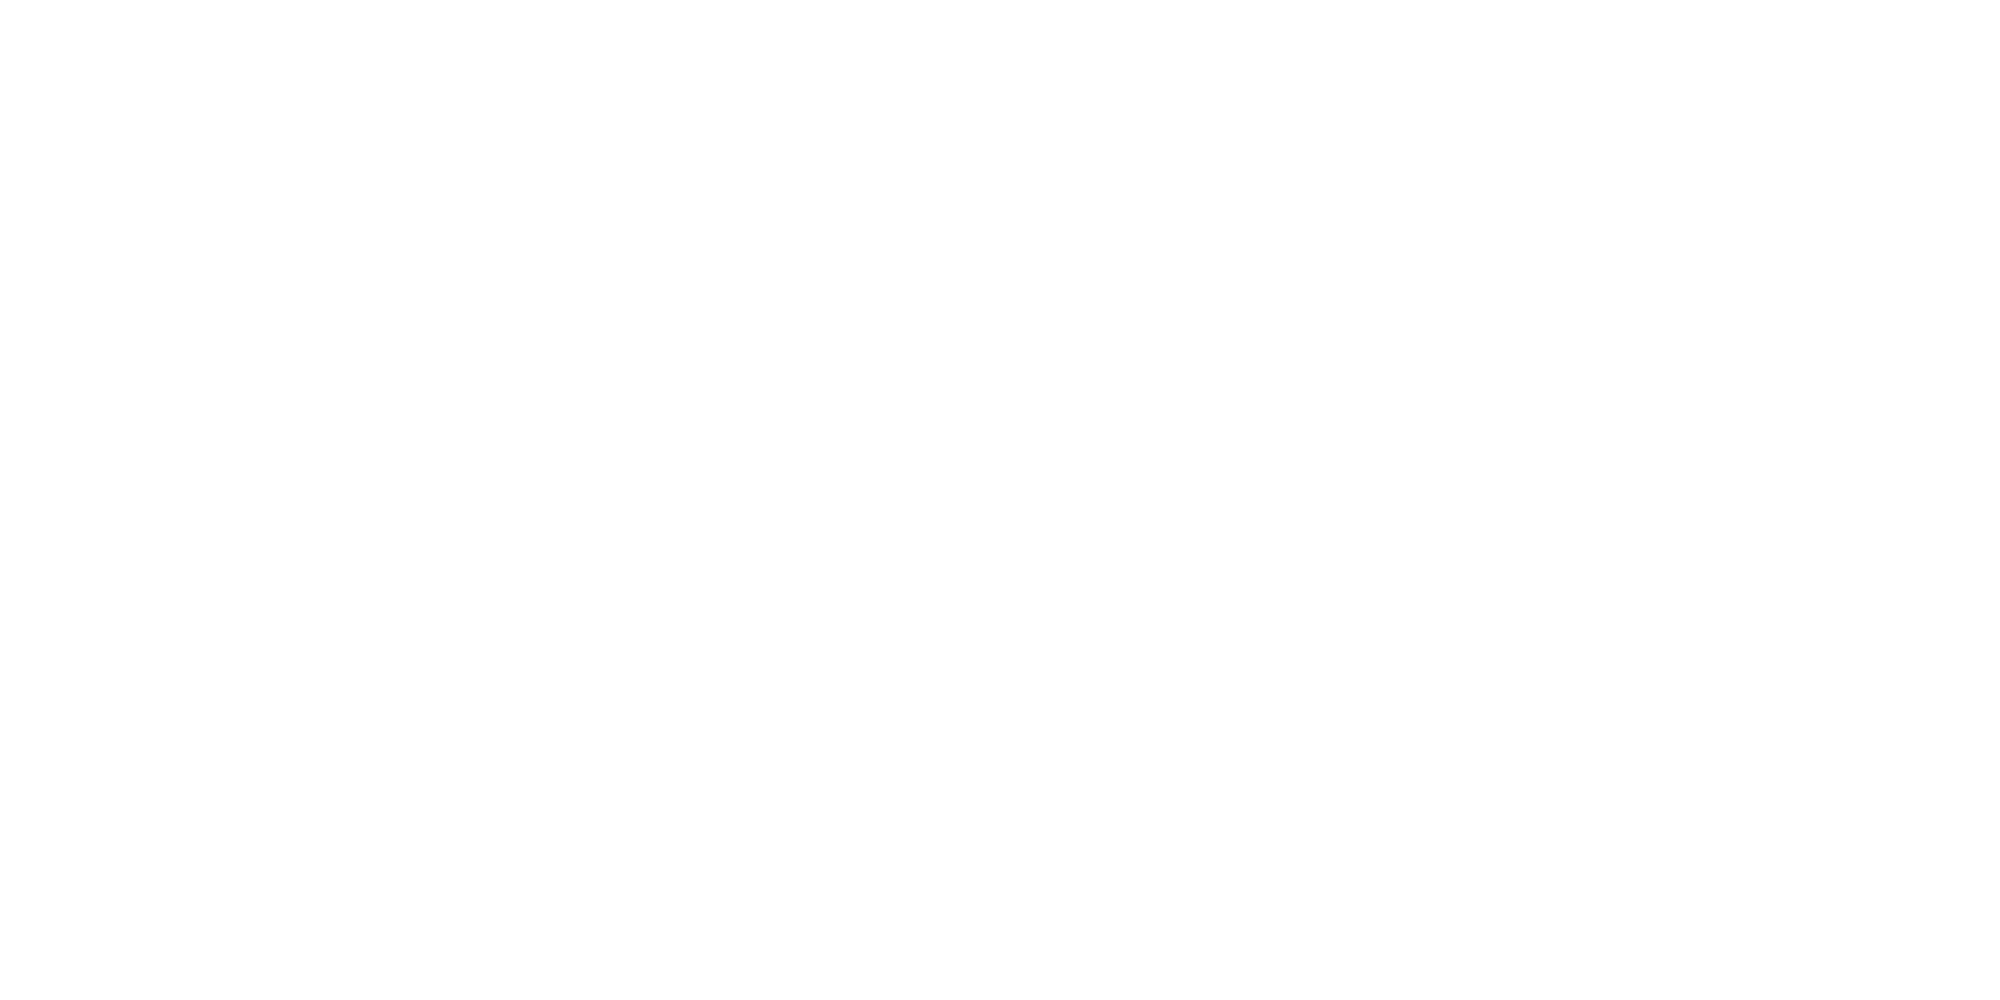

In [9]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386):
    
    #plt.plot(rf_freq, data_noise_on[i], label='ON')
    plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise Off Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 

<IPython.core.display.Javascript object>


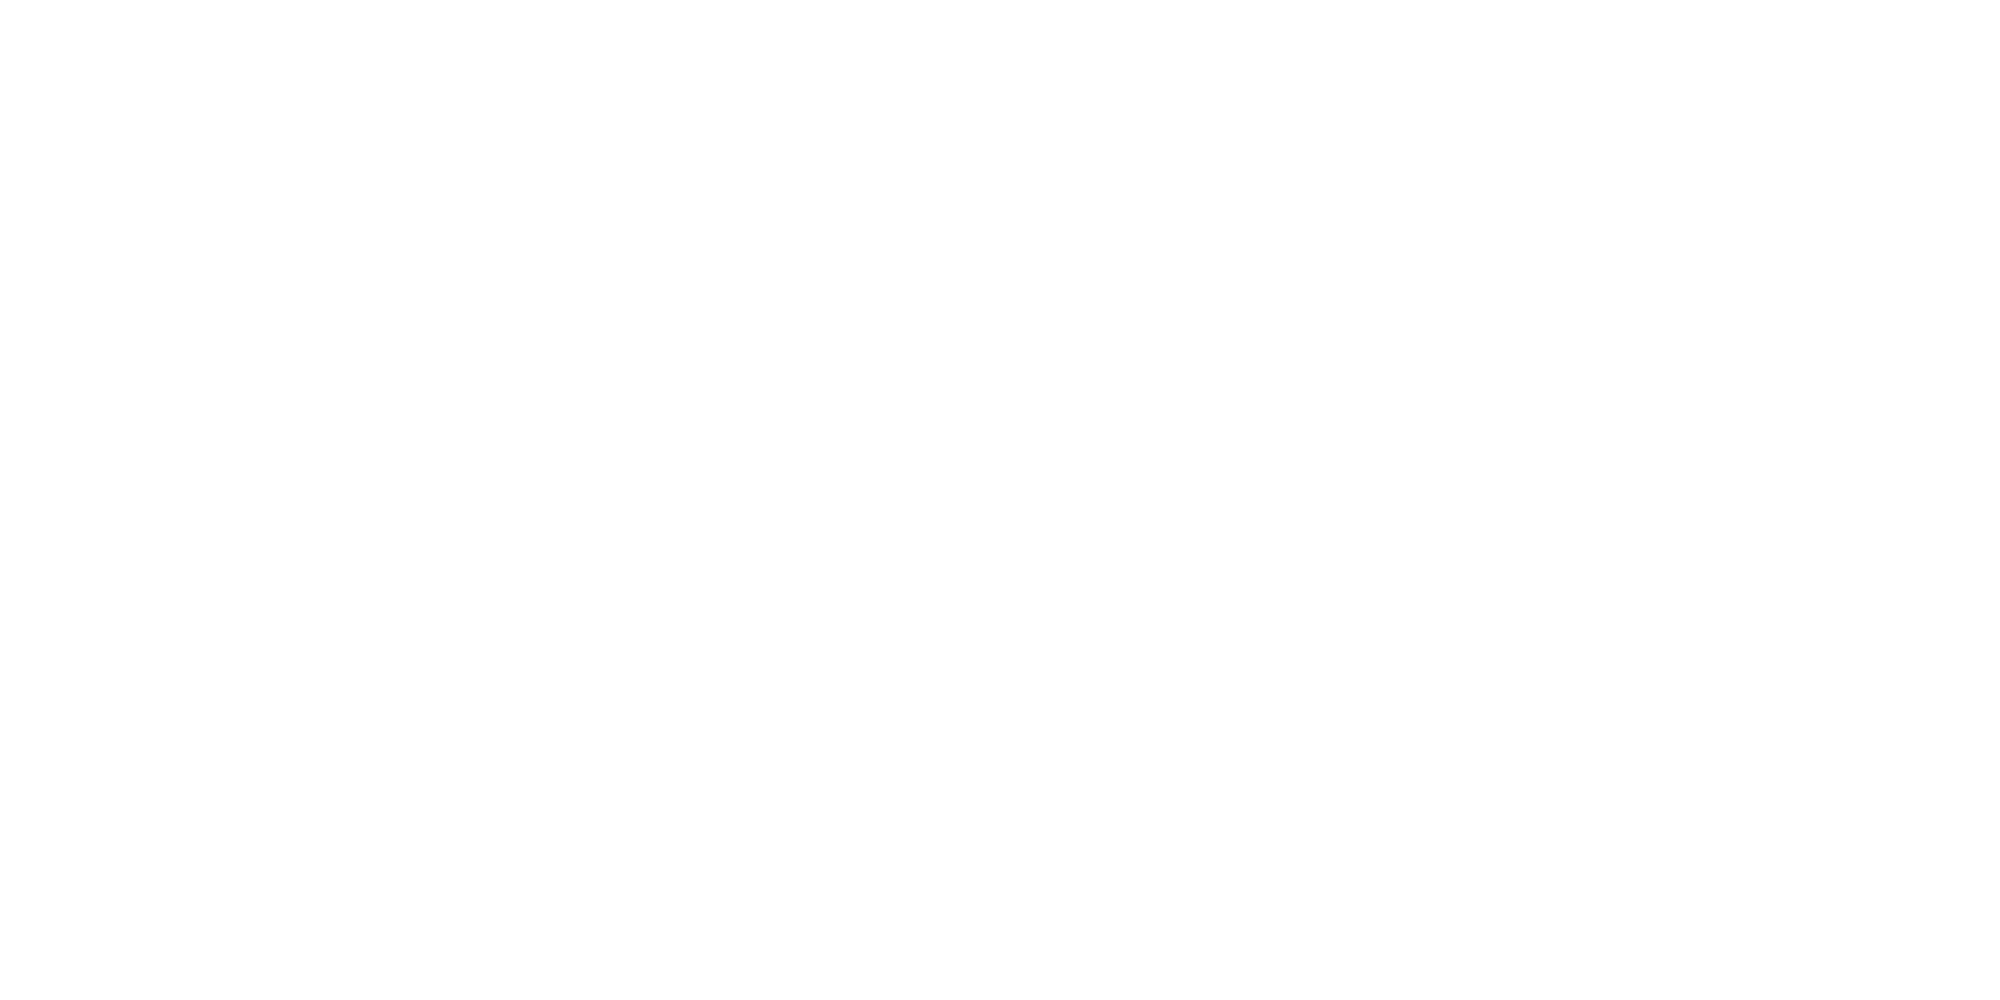

In [10]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386):
    
    plt.plot(rf_freq, data_noise_on[i])
    #plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise On Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 

# Calibration 

In [11]:
import tqdm 

In [12]:
data_noise_on[i].shape[0]

8192

<IPython.core.display.Javascript object>


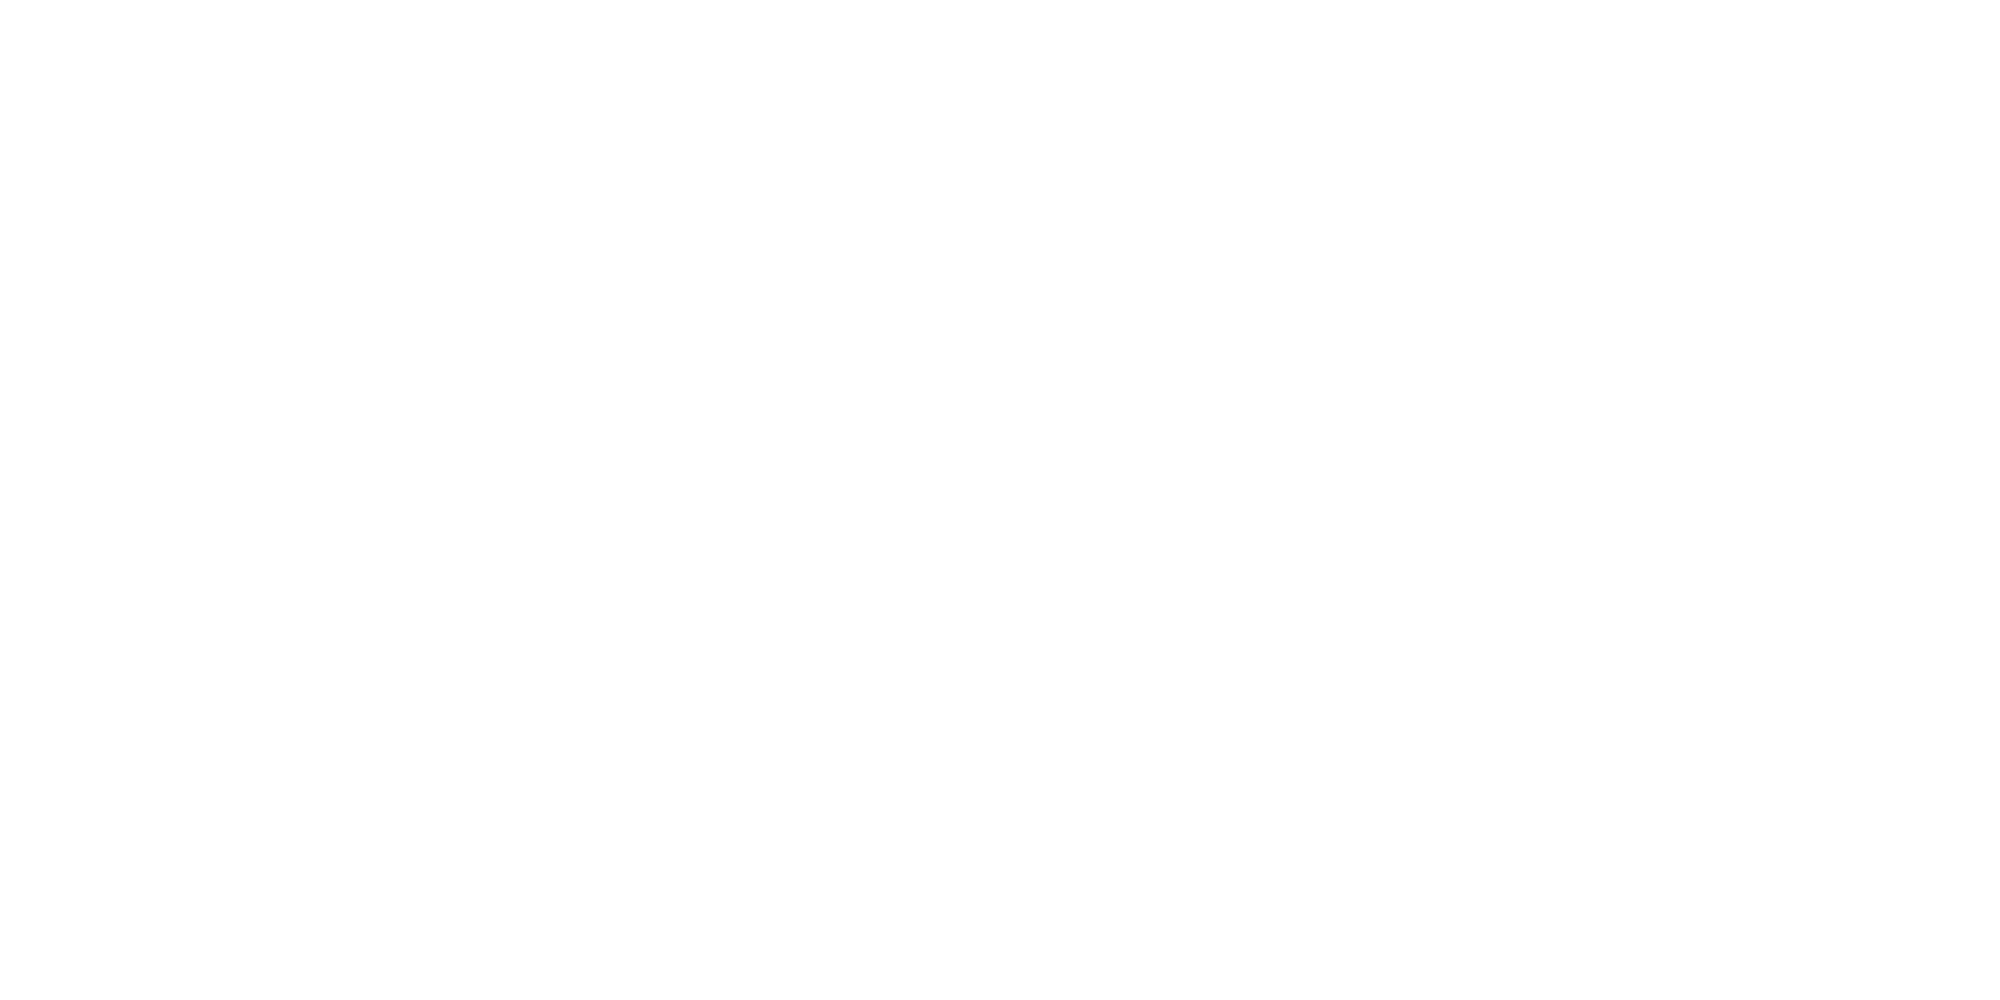

100%|██████████| 5/5 [00:00<00:00, 14.93it/s]


In [13]:
# are these values correct?
t_noise = 90
t_sys = 2.5

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='dodgerblue', label='HI Line')
plt.title('Calibrated Noise Off', fontsize=15)

for i in tqdm.tqdm(range(0, 386, 80)):
    
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line), label='ON') #off

    plt.plot(rf_freq, g*fit, "r")

In [14]:
calibrated_noise_off_spectra = []

<IPython.core.display.Javascript object>


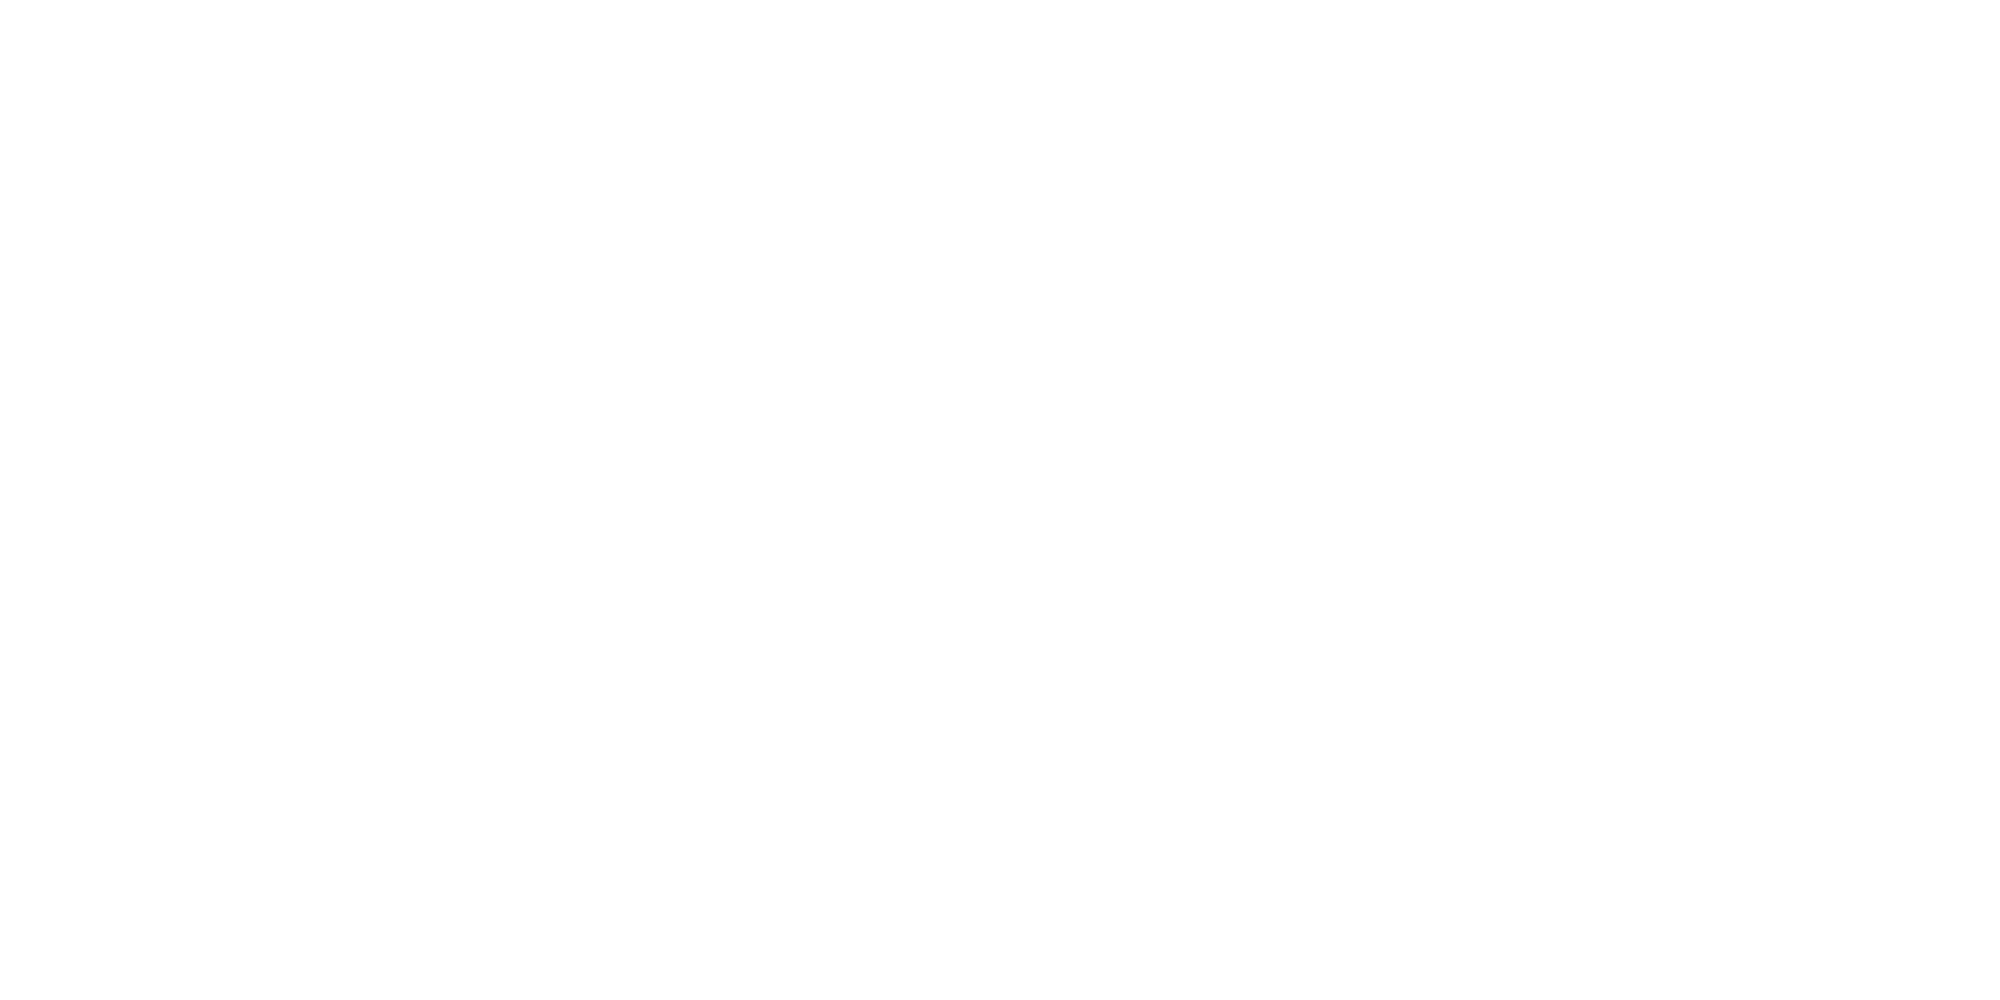

100%|██████████| 386/386 [00:01<00:00, 207.88it/s]


In [15]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.axvline(1420.405, color='dodgerblue', label='HI Line')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)

for i in tqdm.tqdm(range(0, 386)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line - fit), label='ON') #off
    
    calibrated_noise_off_spectra.append(g*(s_line - fit))

<IPython.core.display.Javascript object>


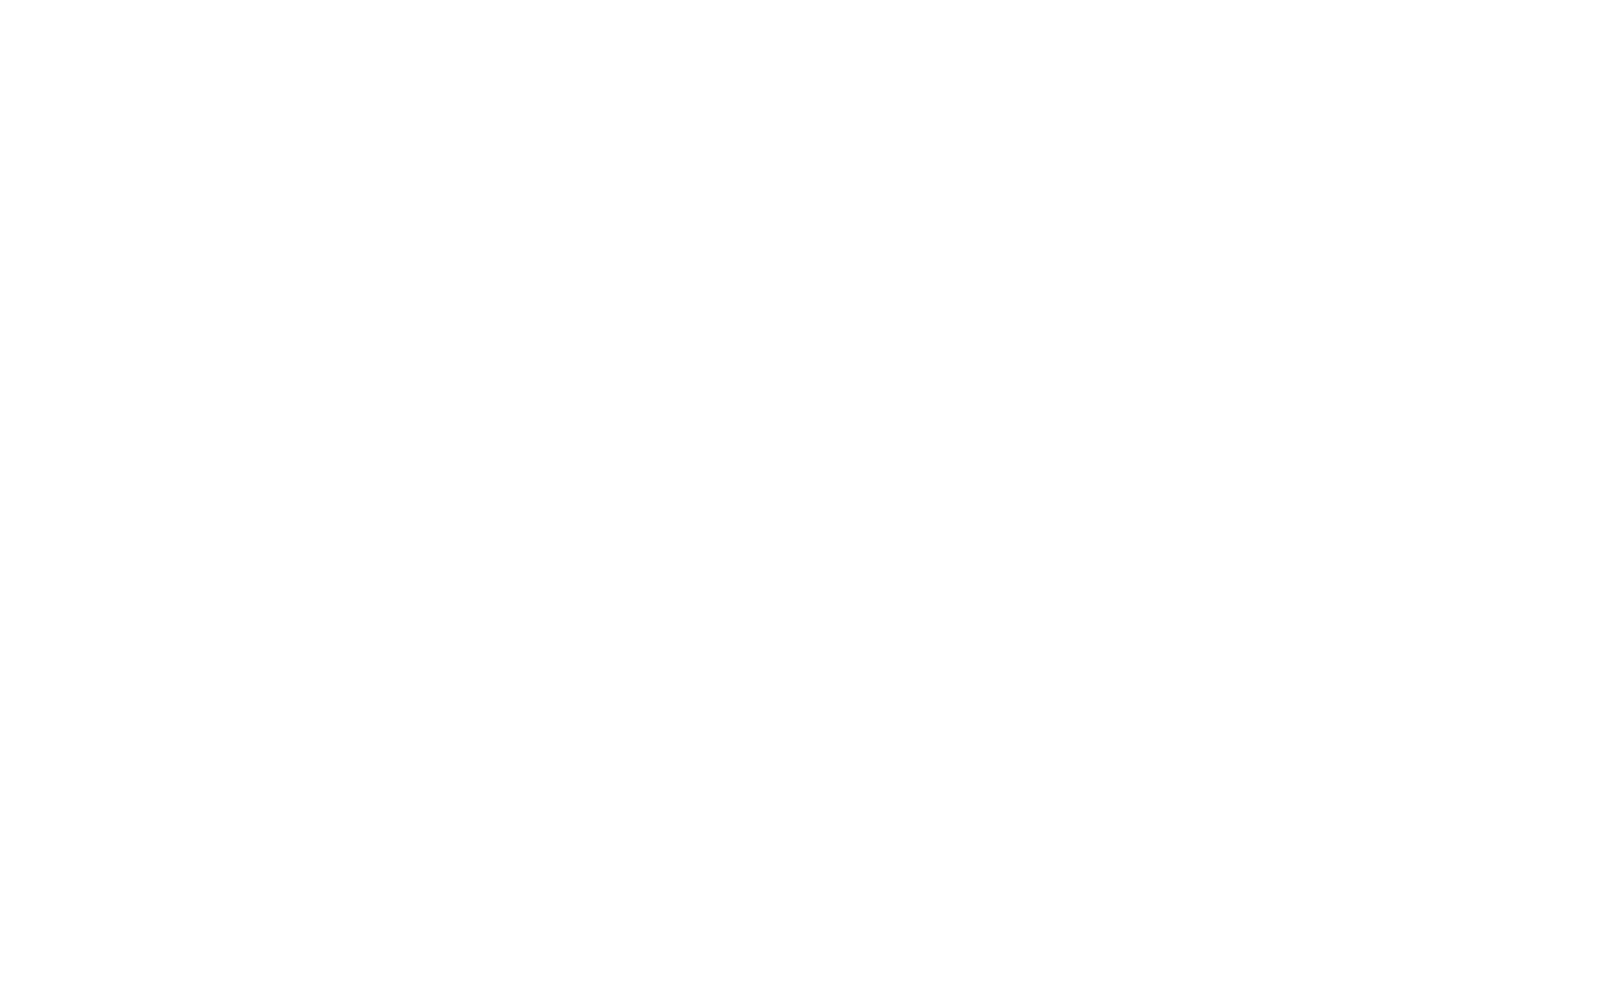

  0%|          | 0/386 [00:00<?, ?it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
 17%|█▋        | 64/386 [00:00<00:03, 83.19it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
 34%|███▎      | 130/386 [00:01<00:03, 71.82it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
 50%|████▉     | 192/386 [00:02<00:03, 63.78it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
 66%|██████▌   | 255/386 [00:03<00:01, 69.10it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
 82%|████████▏ | 318/386 [00:04<00:00, 80.14it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
100%|██████████| 386/386 [00:05<00:00, 72.22it/s]


In [16]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)
calibrated_noise_off_spectra = []
for i in tqdm.tqdm(range(0, 386)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    #line = np.concatenate(s_line[4000:4270],s_line[4470:5000])
    
    
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    filt_freq = rf_freq[index]
    filt_power = s_line[index]
    ind_left = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4270]))[0] 
    ind_right = np.where((rf_freq > rf_freq[4470]) & (rf_freq < rf_freq[4650]))[0]
    inds = np.hstack([ind_left, ind_right])
    
    p = np.polyfit(rf_freq[inds], s_line[inds], 7)
    
    fit = np.polyval(p, rf_freq[index])
    
    plt.axvline(rf_freq[4270], color='dodgerblue')
    plt.axvline(rf_freq[4470], color='dodgerblue')
    
    plt.plot(rf_freq[index], g*(s_line[index] - fit), label='ON') #off
    calibrated_noise_off_spectra.append(g*(s_line[index] - fit))

In [17]:
#there is still ripple gain

#get rid by fitting region where the spike is not

#spike will be at different - look at a few spectra and see where spike moves to, how much it changes
#how fast do we expect the area around the north celecstial pole to 
#use that to find out how redshfited/ doppler shifted the object is 

#exclude frequencies -- use cursor to find right and left bounds on frequency on 5 or 10 random files -- break them up
#polyfit exluding peak but include region set around peak
#to make sure our peak is closer to zero

# Next Steps

In [18]:
galactic_1d_grid = []
galactic_latitude_array = np.arange(15, 41, 2)
galactic_longitude_array = np.arange(105, 160, 2)

for lat in galactic_latitude_array:
    for long in galactic_longitude_array:
        galactic_1d_grid.append((lat, long))
        
# get l,b for each spectra
# select 21cm line, and stick power into each grid 
# missing velocity - 
# low freq, mid freq, and high freq grids 

In [19]:
# 2d_array same size as galactic grid
# pick channel that span, sum it all up, get one number

# calibrated_noise_off_spectra
# axis 1 : long, axis 2: lat, axis 3: vel 

In [20]:
# sum up hi line power for each pointing
# finds out how much hydrogen per pointing
# select blue shifted hydrogen
# select red shifted hydrogen 

f_0 = 1420.4 #MHz
c = 3e8 #m/s
power_grid = []
intensity_grid = []
column_density_grid = []
for spectra in calibrated_noise_off_spectra:
    
    power = np.sum(spectra)
    #power = np.mean(spectra[4270 : 4470]) # fix this later # do different slices 
    power_grid.append(power)
    
    spectra_index = list(spectra).index(max(spectra))
    freq = rf_freq[spectra_index]
    brightness_temp = spectra[spectra_index]
    
    intensity = 2*freq**2*(1.381e-23)*brightness_temp/(c**2)
    intensity_grid.append(intensity)
    
    v = freq*c/(2*f_0) * 10e2 # convert to cm/s
    column_density = brightness_temp * v * 1.8e18
    column_density_grid.append(column_density)

In [21]:
d_off = fits.open('../Data/celestial_pole-noiseoff_0.fits')
d_header = dict(d_off[0].header)

In [22]:
power_dict = {}
for i in range(0, len(power_grid)):
    d = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
    d_header = dict(d[0].header)
    coord_tuple = (int(d_header['L']), int(d_header['B']))
    power_dict[coord_tuple] = power_grid[i]

In [23]:
two_d_array_power = [[0 for x in range(15, 42, 2)] for y in range(105, 161, 2)] 
two_d_array_intensity = [[0 for x in range(15, 42, 2)] for y in range(105, 161, 2)] 
two_d_array_density = [[0 for x in range(15, 42, 2)] for y in range(105, 161, 2)] 

In [24]:
i = 0
for elem in power_dict:
    #print(elem[0])
    two_d_array_power[( elem[1] - 105 ) // 2][( elem[0] - 15 ) // 2] = power_grid[i]
    two_d_array_intensity[( elem[1] - 105 ) // 2][( elem[0] - 15 ) // 2] = intensity_grid[i]
    two_d_array_density[( elem[1] - 105 ) // 2][( elem[0] - 15 ) // 2] = column_density_grid[i]
    i += 1

# grid graph for power

<IPython.core.display.Javascript object>


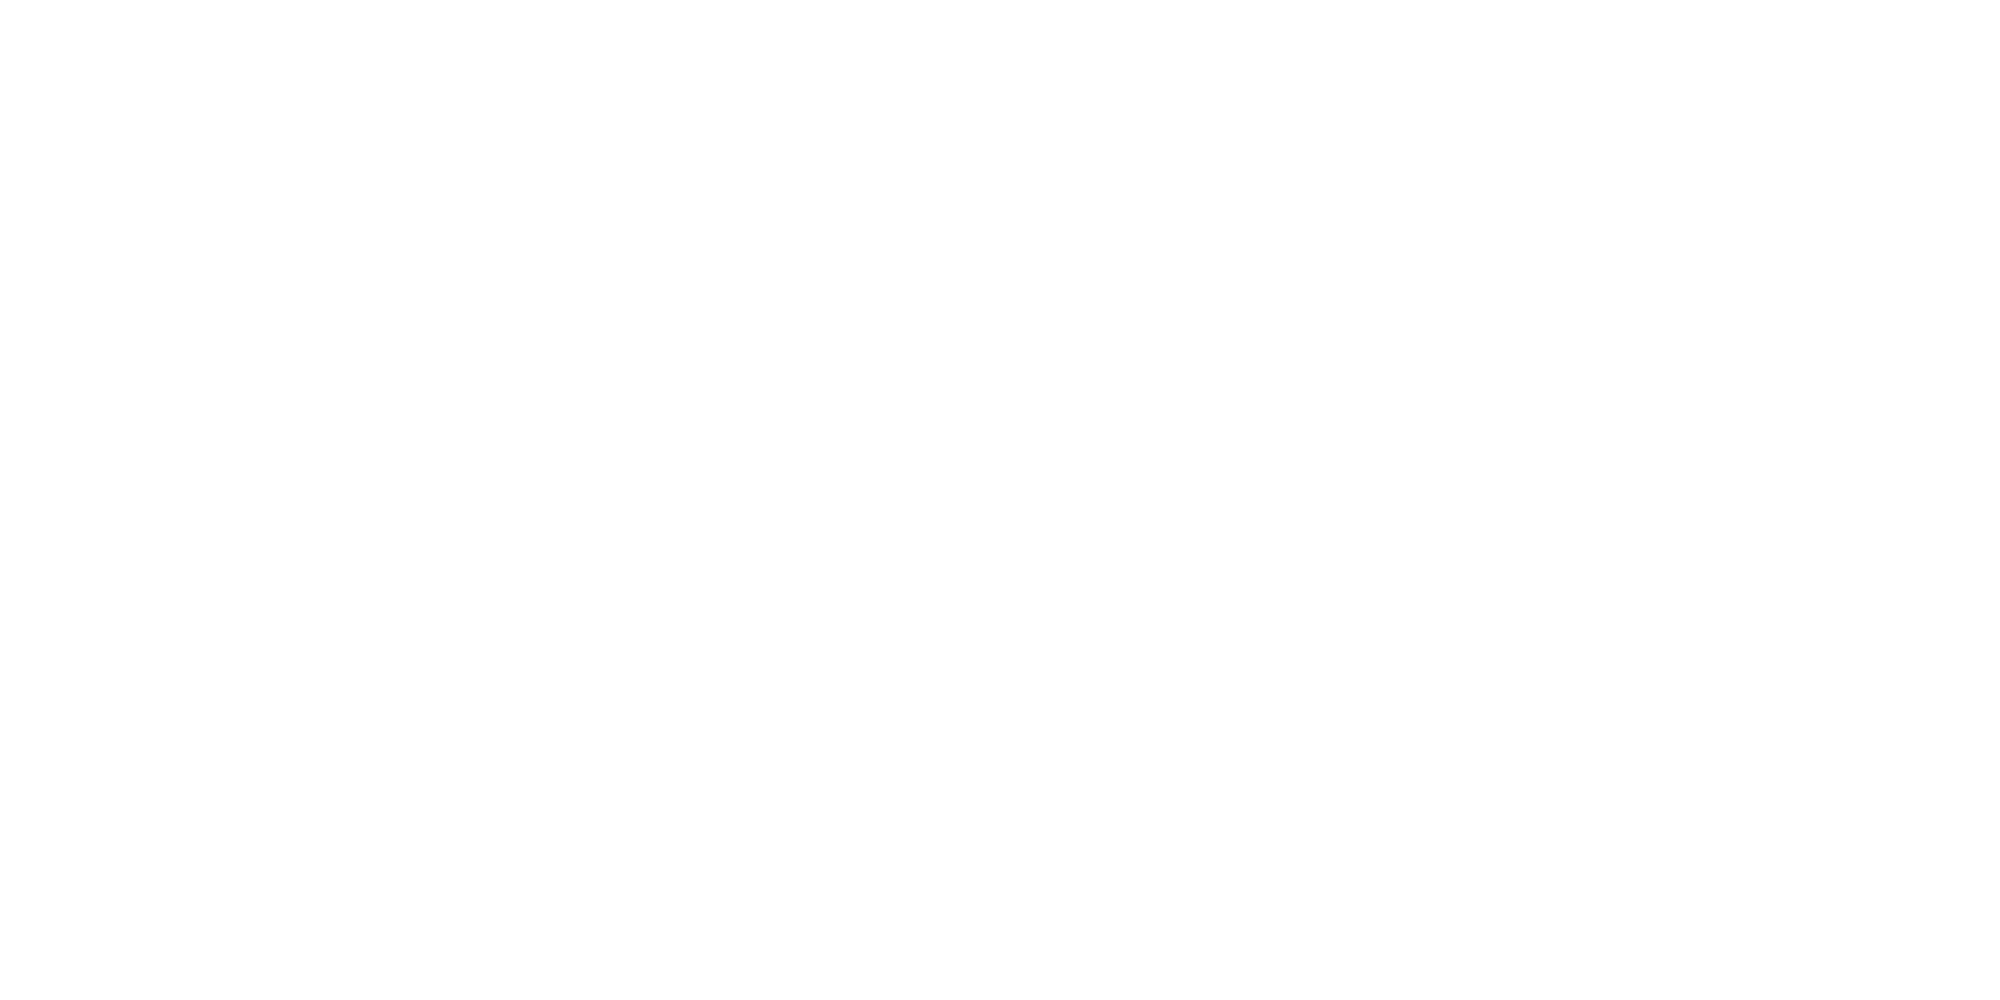

In [25]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(np.array(two_d_array_power).T, aspect='auto', interpolation='gaussian',extent=[105,160,15,41])
plt.title('Power Spectra')
plt.colorbar()

# grid graph for specific intensity

<IPython.core.display.Javascript object>


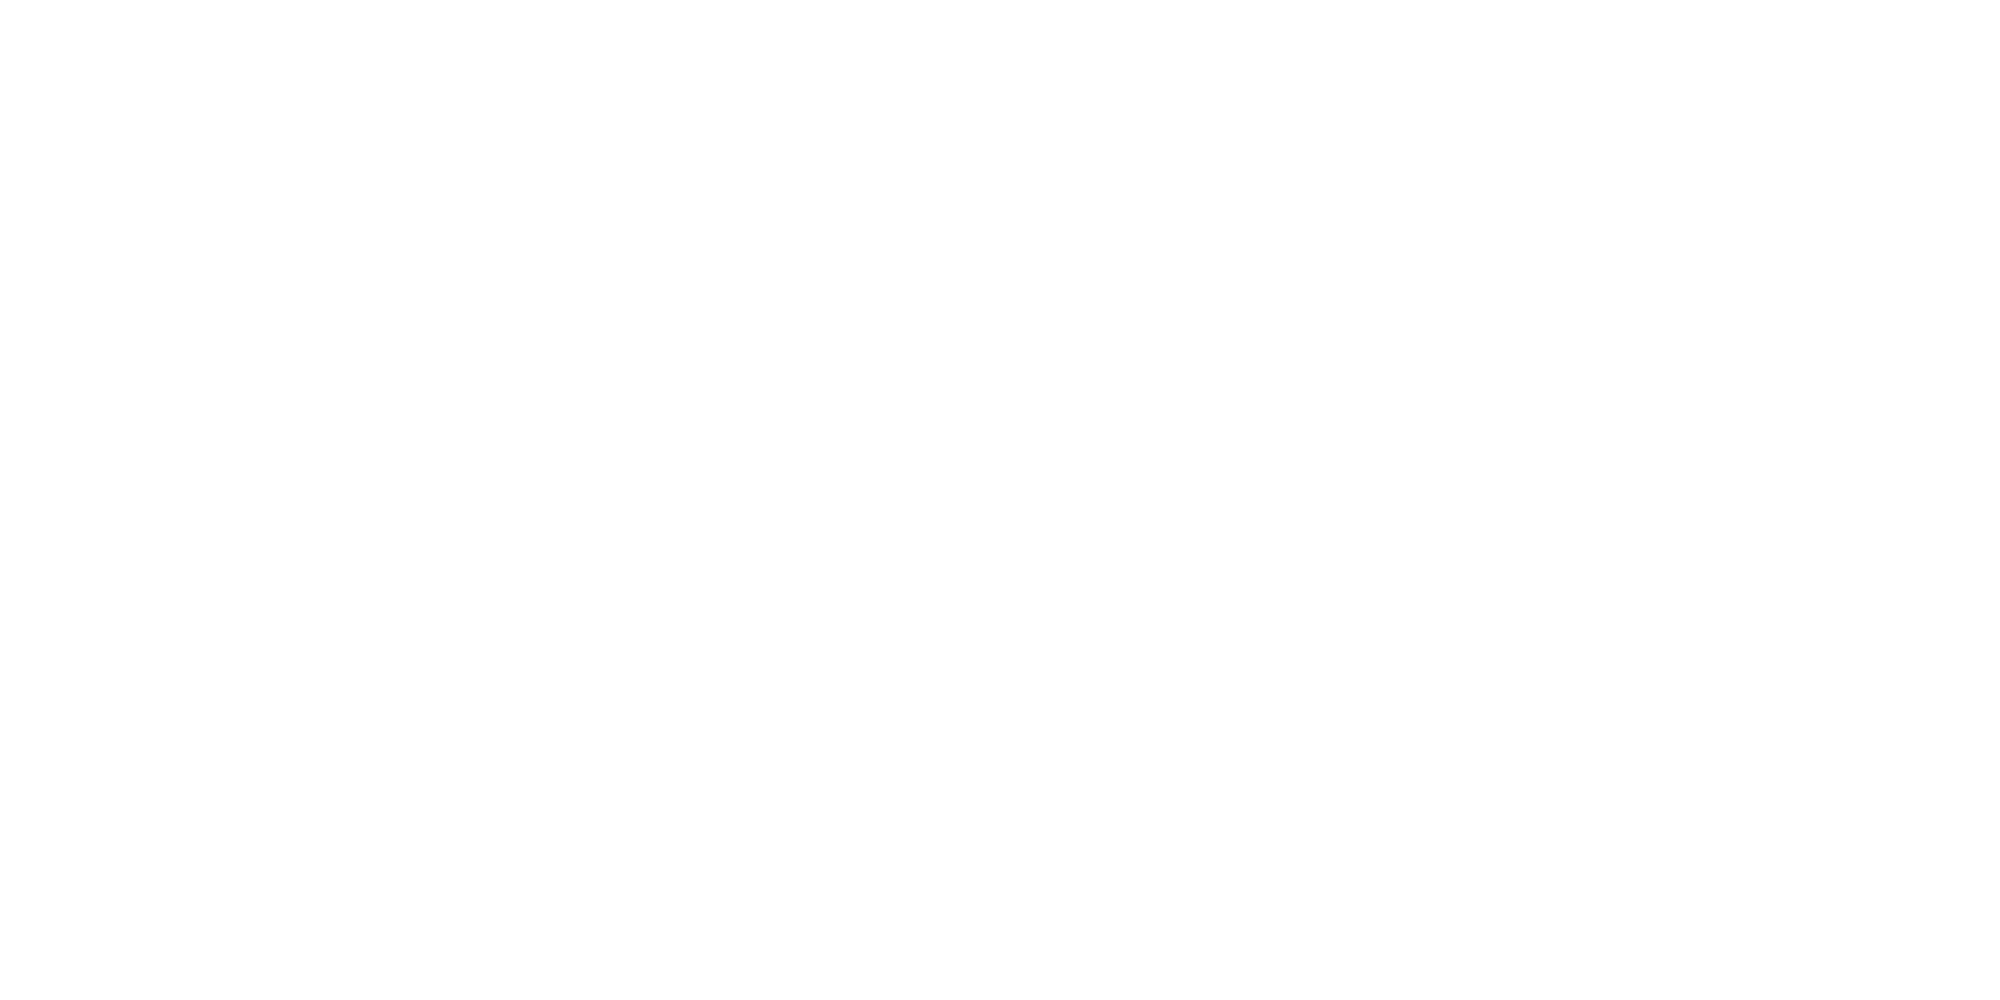

Text(0.5, 1.0, 'Specific Intensity')

In [26]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(np.array(two_d_array_intensity).T, aspect='auto', interpolation='gaussian',extent=[105,160,15,41])

plt.colorbar()
plt.title('Specific Intensity')

# column density of Hydrogen

<IPython.core.display.Javascript object>


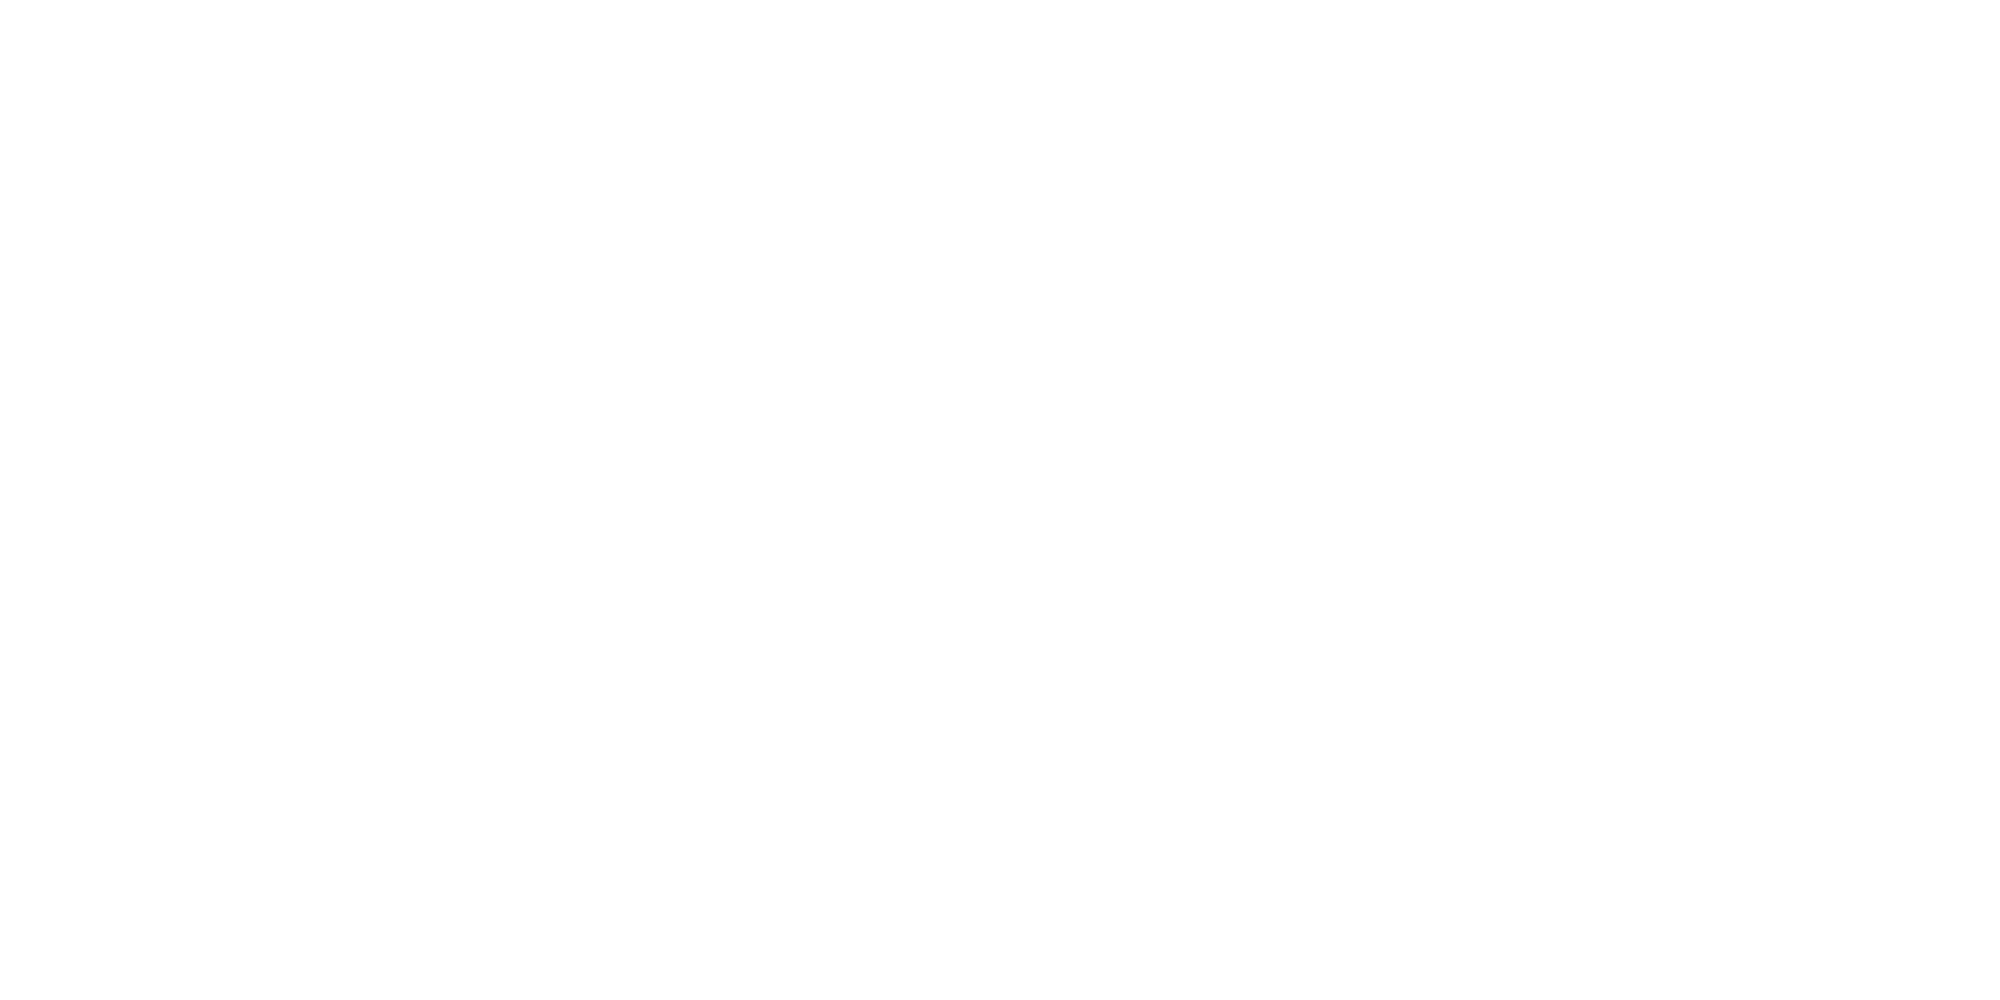

Text(0.5, 1.0, 'Column Density')

In [27]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(np.array(two_d_array_density).T, aspect='auto', interpolation='gaussian',extent=[105,160,15,41])
plt.colorbar()
plt.title('Column Density')

## Doppler Shift

<IPython.core.display.Javascript object>


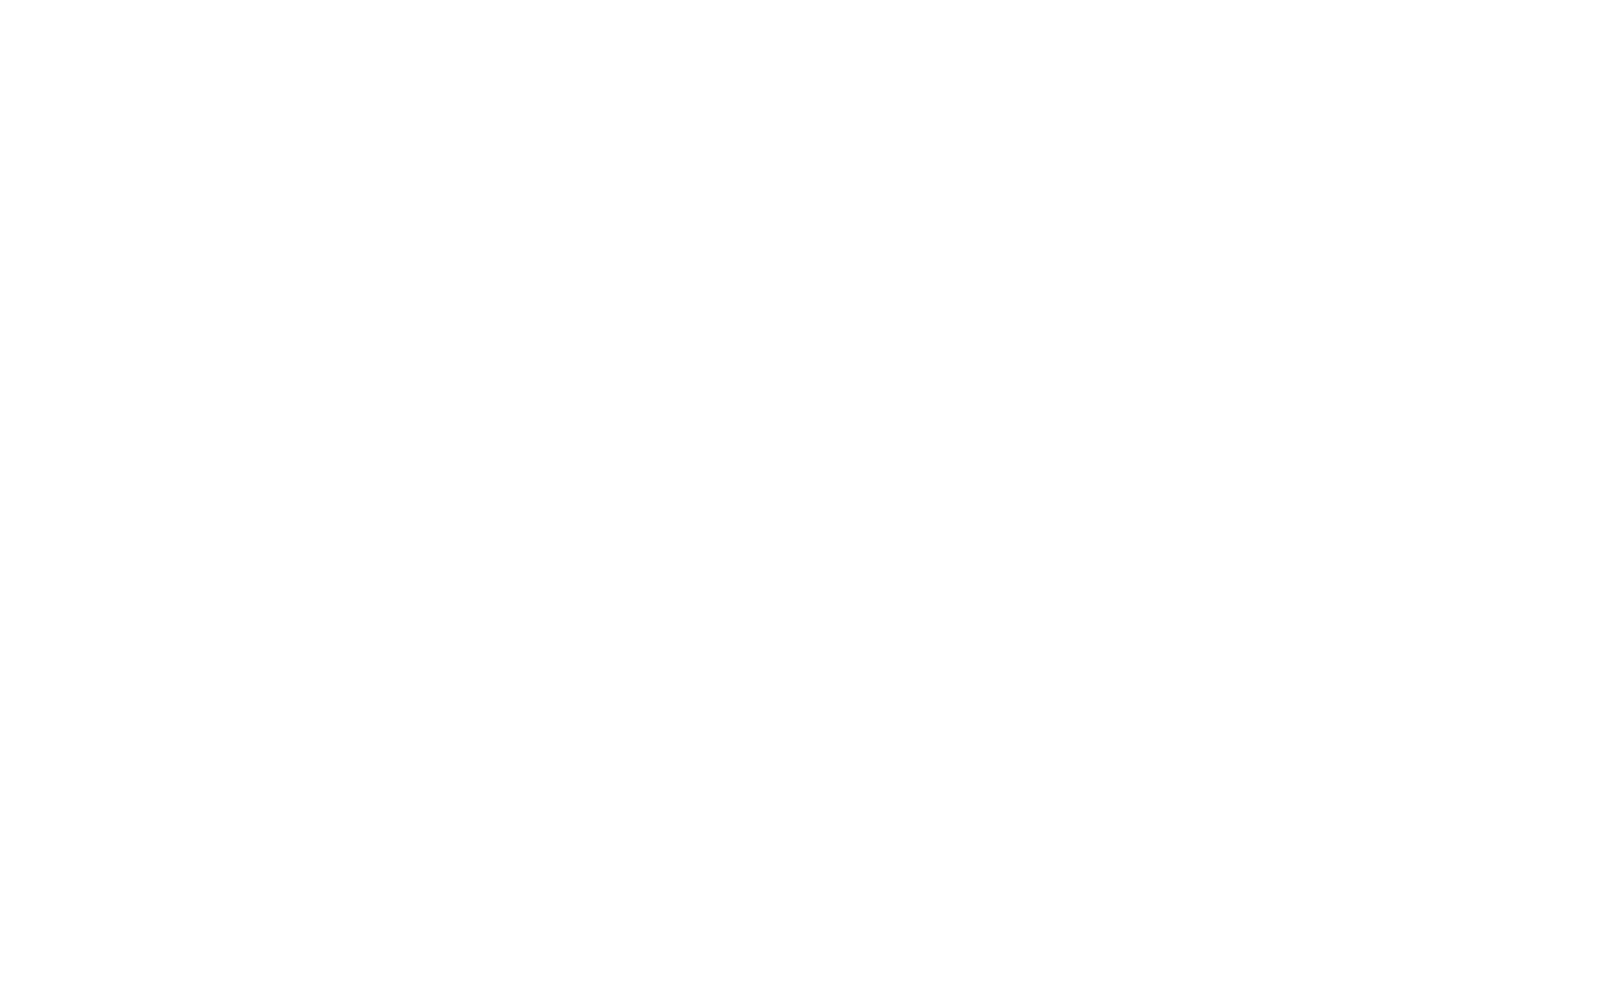

  0%|          | 0/386 [00:00<?, ?it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
 19%|█▉        | 73/386 [00:00<00:02, 128.43it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

 36%|███▌      | 138/386 [00:01<00:02, 82.71it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
 54%|█████▍    | 208/386 [00:02<00:01, 91.66it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
 70%|███████   | 272/386 [00:02<00:01, 78.87it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

 86%|████████▌ | 331/386 [00:03<00:00, 78.42it/s]/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykerne

In [28]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)
calibrated_noise_off_spectra = []
freq_cal = rf_freq[4000:4650]
for i in tqdm.tqdm(range(0, 386)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg

    
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    filt_freq = rf_freq[index]
    filt_power = s_line[index]
    ind_left = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4270]))[0] 
    ind_right = np.where((rf_freq > rf_freq[4470]) & (rf_freq < rf_freq[4650]))[0]
    inds = np.hstack([ind_left, ind_right])
    
    p = np.polyfit(rf_freq[inds], s_line[inds], 7)
    
    fit = np.polyval(p, rf_freq[index])
    
    plt.axvline(rf_freq[4270], color='dodgerblue')
    plt.axvline(rf_freq[4470], color='dodgerblue')
    
    plt.plot(rf_freq[index], g*(s_line[index] - fit), label='ON') #off
    calibrated_noise_off_spectra.append(g*(s_line[index] - fit))
    #for spectra in calibrated_noise_off_spectra:
    
        #plt.plot(freq_cal[list(spectra).index(np.max(spectra))], np.max(spectra), 'o', markersize=5)

In [29]:
#doppler shift yuhhh
nu_0 = 1420.405 #Mhz #hydrogen rest freq
nu = []
c = 3e8 #m/s
velocity = []
for spectra in calibrated_noise_off_spectra:
    spectra_index = list(spectra).index(max(spectra))
    freq = freq_cal[spectra_index]
    nu.append(freq)
    delta_nu = freq - nu_0
    vel = delta_nu * c / nu_0
    velocity.append(vel)
    

<IPython.core.display.Javascript object>


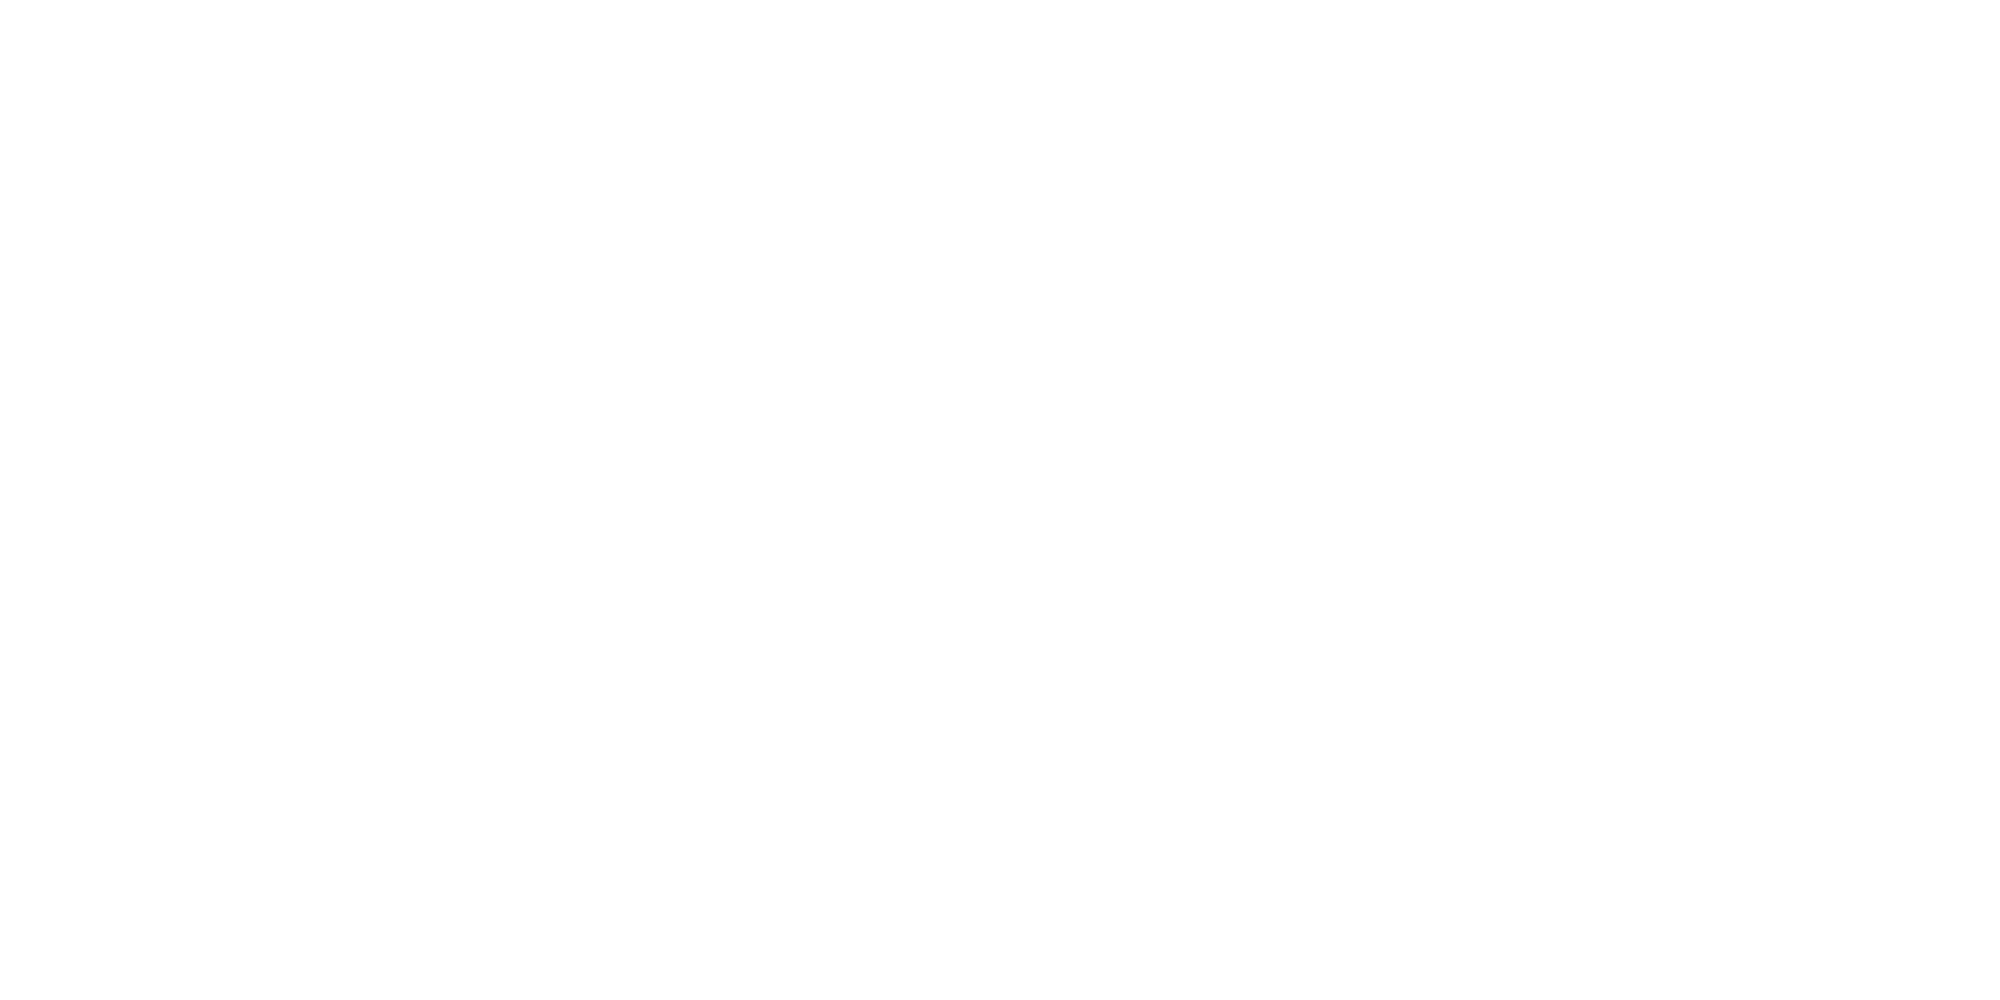

In [30]:
two_d_array_velocity = [[0 for x in range(15, 42, 2)] for y in range(105, 161, 2)] 

velocity_dict = {}
for i in range(0, len(velocity)):
    d = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
    d_header = dict(d[0].header)
    coord_tuple = (int(d_header['L']), int(d_header['B']))
    velocity_dict[coord_tuple] = velocity[i]
    
i = 0  
for elem in velocity_dict:
    two_d_array_velocity[( elem[1] - 105 ) // 2][( elem[0] - 15 ) // 2] = velocity[i]
    i += 1
    
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(np.array(two_d_array_velocity).T, aspect='auto',interpolation='gaussian',extent=[105,160,15,41])
#plt.imshow(two_d_array_velocity, vmax=10000, vmin=-10000, aspect='auto', interpolation='gaussian')

plt.colorbar()

In [31]:
#make map
#change to RA,dec from l,b 

In [32]:
from mpl_toolkits.basemap import Basemap

In [33]:
bmap = Basemap(projection='cyl')
lons, lats = bmap.makegrid(500,500) 


/Users/madeline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


## Error

In [34]:
from astropy import modeling

<IPython.core.display.Javascript object>


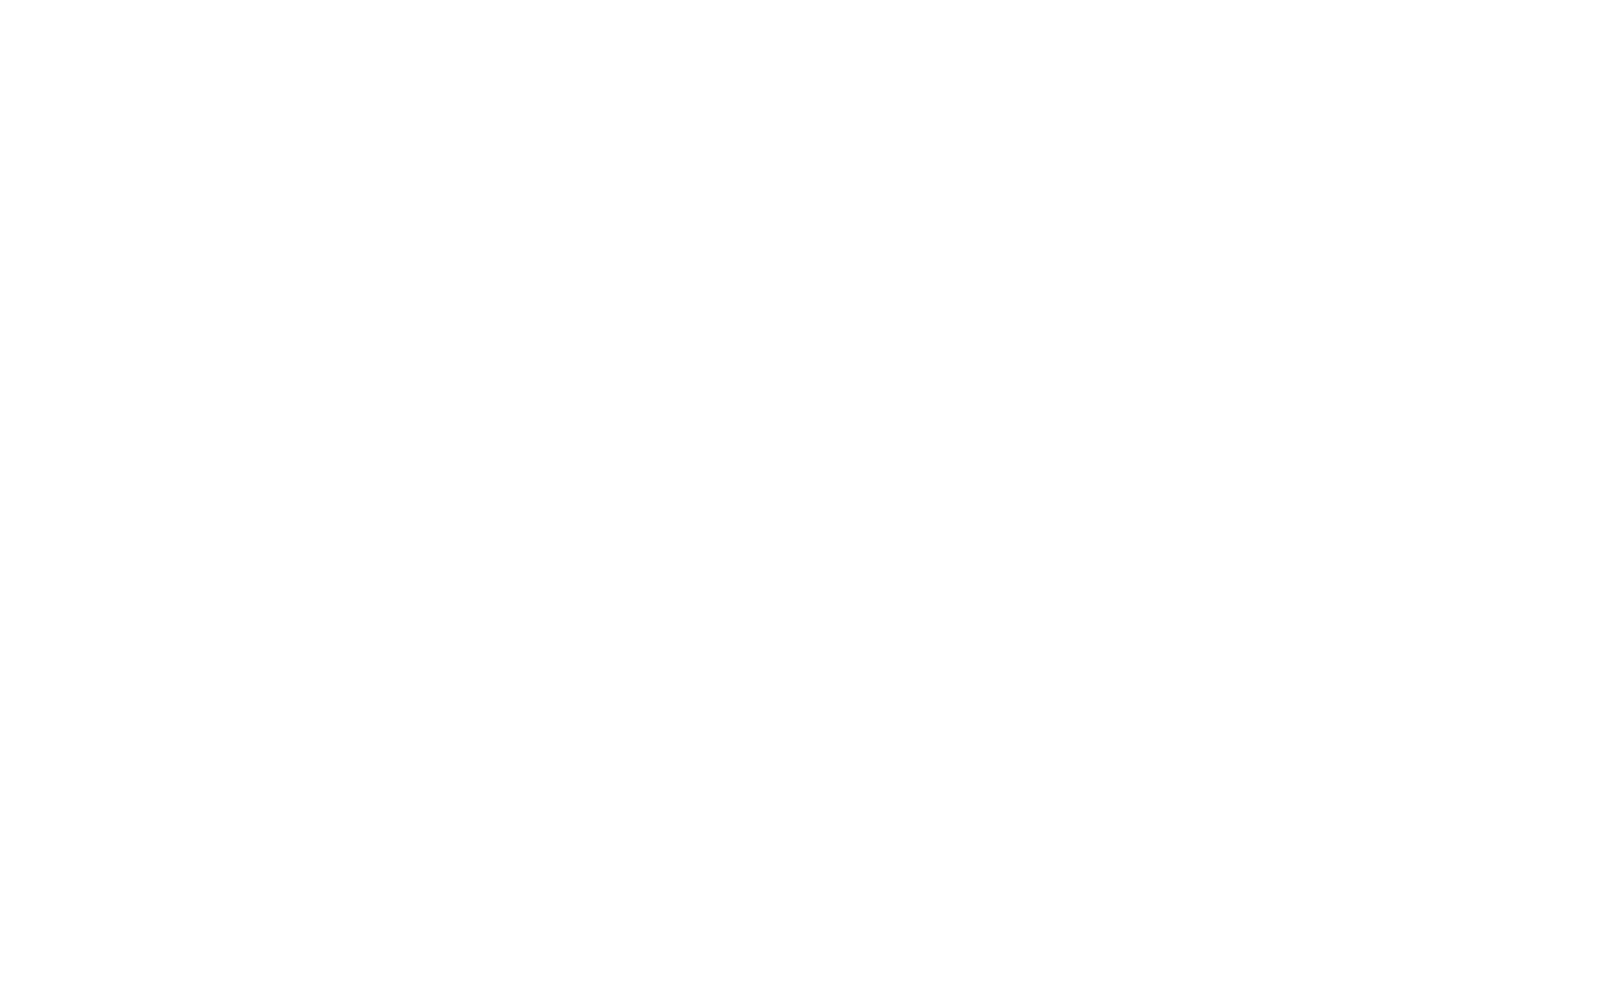

100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


In [35]:
## Error in Brightness temp/amplitude

#git a gaussian to each curve 
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Gauss Fit to Data', fontsize=15)

gauss_fit = []
freq_cal = rf_freq[4000:4650]
for i in tqdm.tqdm(range(0, 1)):
    spectra = calibrated_noise_off_spectra[i]
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    
    amp = np.max(spectra)
    std = np.std(spectra)
    avg = freq_cal[list(spectra).index(max(spectra))]
    m = modeling.models.Gaussian1D(amplitude=amp, mean=avg, stddev=std)
    x = rf_freq[index]
    data = m(x)
    data = data + np.sqrt(data)*np.random.random(x.size)-0.5
    data -= data.min()
    fitter = modeling.fitting.LevMarLSQFitter()
    model = modeling.models.Gaussian1D()
    fitted_model = fitter(model, x, data)
    
    #filt_freq = rf_freq[index]
    #filt_power = s_line[index]
    #ind_left = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4270]))[0] 
    #ind_right = np.where((rf_freq > rf_freq[4470]) & (rf_freq < rf_freq[4650]))[0]
    #inds = np.hstack([ind_left, ind_right])
    
    #p = np.polyfit(rf_freq[inds], s_line[inds], 7)
    
    #fit = np.polyval(p, rf_freq[index])
    
    plt.axvline(rf_freq[4270], color='dodgerblue')
    plt.axvline(rf_freq[4470], color='dodgerblue')
    
    plt.plot(rf_freq[index], spectra)
    plt.plot(rf_freq[index][274:470], spectra[274:470])
    plt.plot(rf_freq[index], fitted_model(x), 'r', label='Fit')
    gauss_fit.append(data)

In [36]:
from scipy import optimize

In [37]:
from ugradio import gauss
from scipy.optimize import fmin

In [44]:

amp2 = np.max(calibrated_noise_off_spectra[1])
avg2 = freq_cal[list(calibrated_noise_off_spectra[1]).index(max(calibrated_noise_off_spectra[1]))]
sig2 = rf_freq[4470]-rf_freq[4270]
print(amp2)

187.32586001970878


<IPython.core.display.Javascript object>


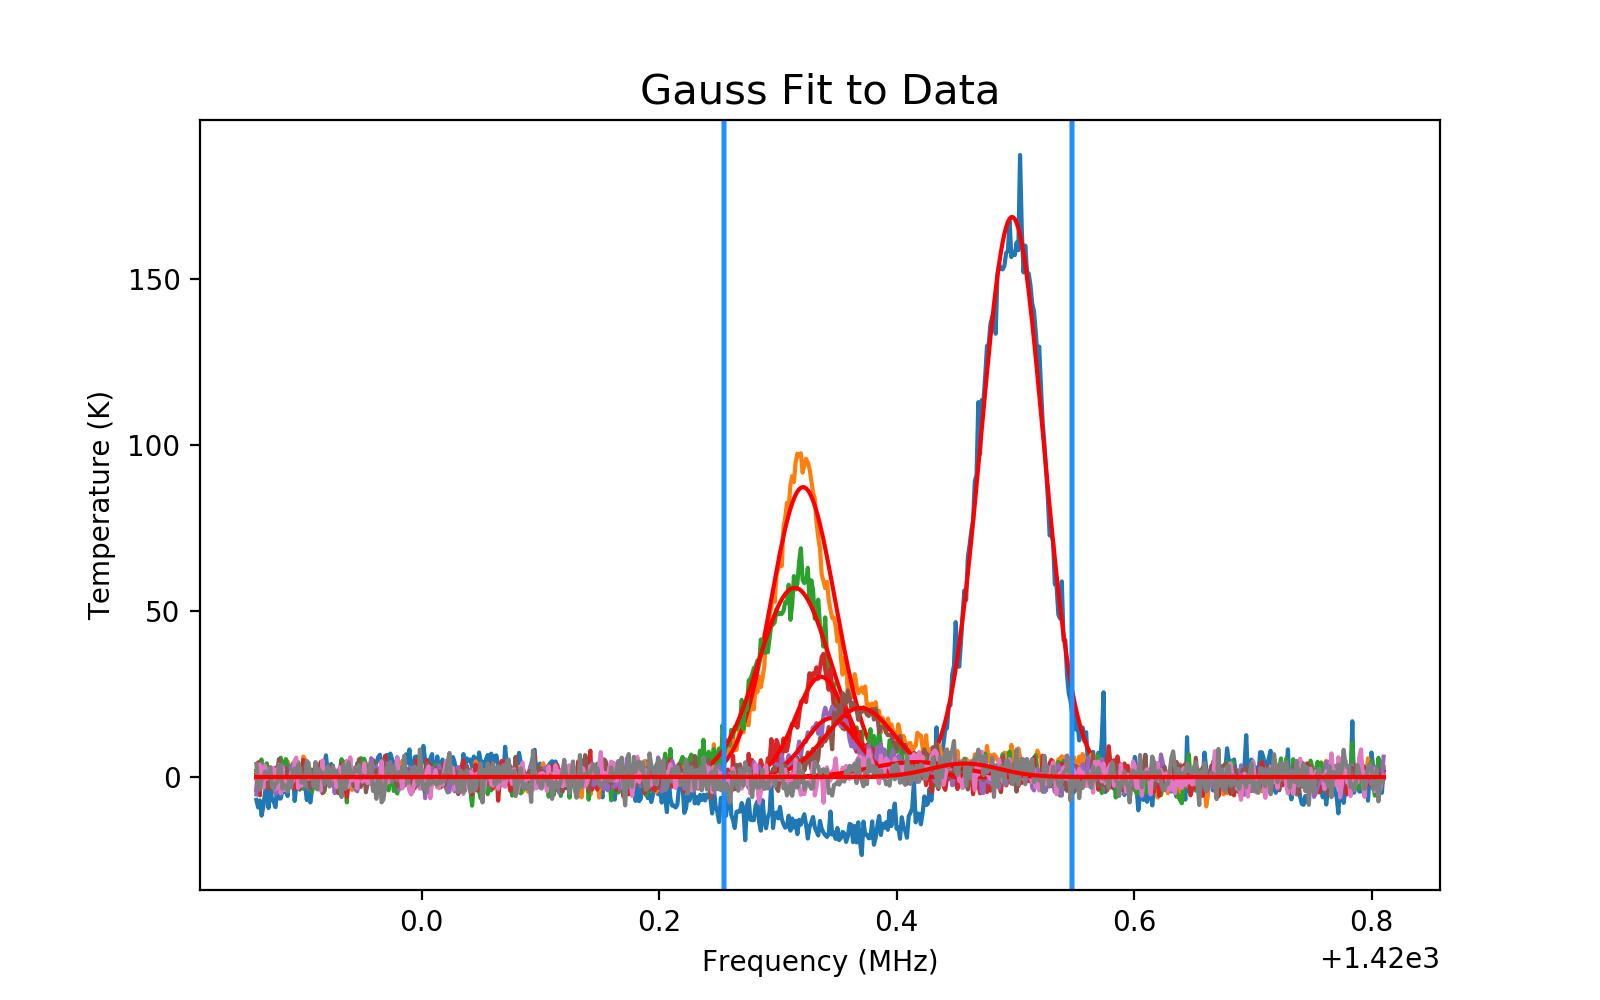

100%|██████████| 8/8 [00:00<00:00, 42.39it/s]


In [88]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Gauss Fit to Data', fontsize=15)

gauss_fit = []
freq_cal = rf_freq[4000:4650]
for i in tqdm.tqdm(range(1, 386,51)):
    spectra = calibrated_noise_off_spectra[i]
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    amp2 = np.max(spectra)
    avg2 = freq_cal[list(spectra).index(max(spectra))]
    sig2 = rf_freq[4470]-rf_freq[4270]
    d = {'amp' : amp2, 'avg':avg2, 'sig': sig2}
    gauss_fit = ugradio.gauss.gaussfit(rf_freq[index], spectra, **d)
    gauss_val = ugradio.gauss.gaussval(rf_freq[index], **gauss_fit)
    
    plt.axvline(rf_freq[4270], color='dodgerblue')
    plt.axvline(rf_freq[4470], color='dodgerblue')
    
    plt.plot(rf_freq[index], spectra, label='Data')
    plt.plot(rf_freq[index], gauss_val, 'r', label='Fit')
    #gauss_fit.append(data)
    #[274:470]

In [67]:

fit_gauss = []
fit_fitg = []
freq_cal = rf_freq[4000:4650]
for i in tqdm.tqdm(range(0, 386)):
    spectra = calibrated_noise_off_spectra[i]
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    amp2 = np.max(spectra)
    avg2 = freq_cal[list(spectra).index(max(spectra))]
    sig2 = rf_freq[4470]-rf_freq[4270]
    d = {'amp' : amp2, 'avg':avg2, 'sig': sig2}
    gauss_fit = ugradio.gauss.gaussfit(rf_freq[index], spectra, **d)
    gauss_val = ugradio.gauss.gaussval(rf_freq[index], **gauss_fit)
    fit_fitg.append(gauss_fit)
    fit_gauss.append(gauss_val)


100%|██████████| 386/386 [00:02<00:00, 180.27it/s]


In [63]:
fit_error = []
for i in tqdm.tqdm(range(0, 386)):
    spectra = calibrated_noise_off_spectra[i]
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    amp2 = np.max(spectra)
    avg2 = freq_cal[list(spectra).index(max(spectra))]
    sig2 = rf_freq[4470]-rf_freq[4270]
    d = {'amp' : amp2, 'avg':avg2, 'sig': sig2}
    _,gauss_fit_error = ugradio.gauss.gaussfit(rf_freq[index], spectra, return_cov=True, **d)
    fit_error.append(gauss_fit_error)
    
amperr = []
avgerr = []
sigerr = []
for i in tqdm.tqdm(range(0, 386)):
    spectra = calibrated_noise_off_spectra[i]
    amp_error = ((np.diag(fit_error[i])[0])**0.5)
    avg_error = ((np.diag(fit_error[i])[1])**0.5)
    sig_error = ((np.diag(fit_error[i])[2])**0.5)
    amperr.append(amp_error)
    avgerr.append(avg_error)
    sigerr.append(sig_error)

100%|██████████| 386/386 [00:00<00:00, 32497.02it/s]


In [94]:
for i in range(len(calibrated_noise_off_spectra)):
    stuff1 = []
    if amperr[i] < 1000000:
        stuff1.append(amperr[i])
    else:
        pass
print('avg amplitude error is: '+str(np.mean(stuff1)))

avg amplitude error is: 0.4351877491739809


In [95]:
for i in range(len(calibrated_noise_off_spectra)):
    stuff2 = []
    if avgerr[i] < 1000000:
        stuff2.append(avgerr[i])
    else:
        pass
print('avg freq error is: '+str(np.mean(stuff2)))

avg freq error is: 0.004315271330111131


In [96]:
for i in range(len(calibrated_noise_off_spectra)):
    stuff3 = []
    if sigerr[i] < 1000000:
        stuff3.append(sigerr[i])
    else:
        pass
print('avg width error is: '+str(np.mean(stuff3)))

avg width error is: 0.004315271284852016


In [48]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)
chis = []
for i in range(0,386):
    spectra = calibrated_noise_off_spectra[i]
    sigma = np.std(spectra[0:100])
    chi = chisq(spectra, fit_gauss[i], sigma)
    chis.append(chi)

In [71]:
import copy

In [78]:
#error on amp:
chi_dif = []
for i in range(0,386):
    spectra = calibrated_noise_off_spectra[i]
    fit = copy.copy(fit_fitg[i])
    fit['sig']=0.03118225
    gauss_val2 = ugradio.gauss.gaussval(rf_freq[index], **fit)
    sigma = np.std(spectra[0:100])
    chinew = chisq(spectra, gauss_val2, sigma)
    chidiff = chis[i]-chinew
    chi_dif.append(chidiff)